# Семинар 11: Деревья решений. Ансамбль моделей: бэггинг (bagging = bootstrap aggregating), случайный лес (random forest) и бустинг (boosting)

In [2]:
%matplotlib inline
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import seaborn as sns; sns.set()

from ipywidgets import interact

In [3]:
random_seed = 42

In [4]:
def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow', clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)

def plot_tree_interactive(X, y):
    def interactive_tree(depth=7):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)
    return interact(interactive_tree, depth=[1, 2, 3, 4, 5, 6, 7])

def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        rng = np.random.RandomState(random_state)
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False, xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 25, 50, 75, 100]);

def visualize_classifier(model, X, y, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow', clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
        
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap='rainbow')
    if contour:
        plt.contour(x1, x2, y_pred, alpha=0.8, cmap='rainbow')
       
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## Дерево решений

Дерево решений состоит из набора вложенных правил принятия решений. В каждом узле ``i`` компонента ``d_i`` входного вектора ``x`` сравнивается с пороговым значением ``t_i``, после чего входной вектор передается в левую или правую ветвь, в зависимости от того, выше или ниже. В листьях дерева модель задает прогнозируемый выход для любого входа, который попадает в эту ветвь.

Рассмотрим следующие двумерные данные, где каждая точка принадлежит одному из четырех классов.

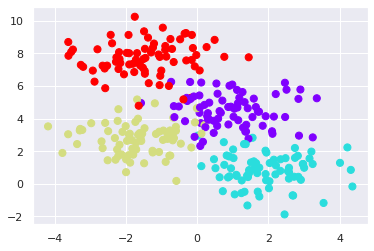

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], cmap='rainbow', c=y, s=50);

Простое дерево принятия решений для этих данных будет многократно разделять
данные по одной или нескольким осям, в соответствии с определенным количественным критерием, и на каждом уровне маркировать новую область согласно большинству лежащих в ней точек.

![](images/05.08-decision-tree-levels.png)

Процесс обучения дерева принятия решений на наших данных можно выполнить в Scikit-Learn посредством ``DecisionTreeClassifier``.

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X, y)

/tmp/ipykernel_20158/1998487938.py:87: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)


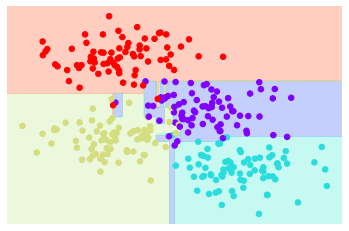

In [7]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [8]:
plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=6, options=(1, 2, 3, 4, 5, 6, 7), value=7), Output()…

### Деревья решений и переобучение

По мере возрастания глубины мы получаем области классификации очень странной формы. 
Такая конфигурация является скорее не результатом собственно распределения данных, а конкретной их дискретизации или свойств шума в них.
Дерево принятия решений на достаточной глубине уже очевидным образом переобучено.

Другой способ столкнуться с переобучением — обучить пару моделей на различных подмножествах набора данных.

![](images/05.08-decision-tree-overfitting.png)

В некоторых областях результаты двух деревьев не противоречат друг другу, а в других областях их классификации очень
сильно различаются (например, в областях между любыми двумя кластерами).
Расхождения имеют тенденцию появляться в тех местах, где степень достоверности классификации ниже, а значит, мы можем
добиться лучшего результата, используя информацию из обоих деревьев!

Рассмотрим деревья решений, обученные на случайных подмножествах исходного набора данных.

In [9]:
randomized_tree_interactive(X, y);

interactive(children=(Dropdown(description='random_state', options=(0, 25, 50, 75, 100), value=0), Output()), …

## Ансамбль моделей: бэггинг (bagging = bootstrap aggregating)

Метод построения ансамбля моделей, при котором базовые модели обучаются независимо на различных случайных подвыборках исходного набора данных.

Выполнить подобную бэггинг-классификацию можно вручную с помощью метаоценивателя ``sklearn.ensemble.BaggingClassifier`` из библиотеки Scikit-Learn.

/tmp/ipykernel_20158/1998487938.py:87: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)


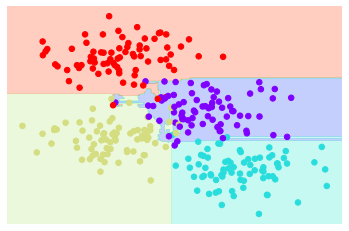

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree     import DecisionTreeClassifier


tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=42)

bag.fit(X, y)
visualize_classifier(bag, X, y)

## Ансамбль моделей: случайный лес (random forest)



В библиотеке Scikit-Learn есть отдельная модель ``sklearn.ensemble.RandomForestClassifier``.

/tmp/ipykernel_20158/1998487938.py:87: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='rainbow', clim=(y.min(), y.max()), zorder=1)


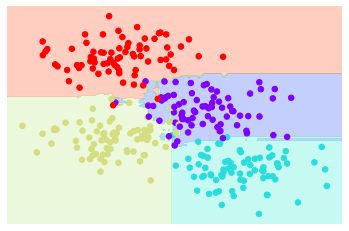

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

In [12]:
from sklearn.datasets        import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

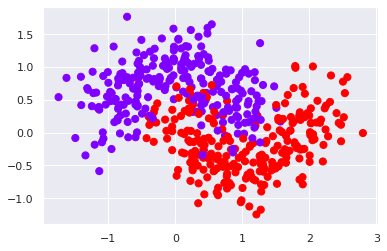

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

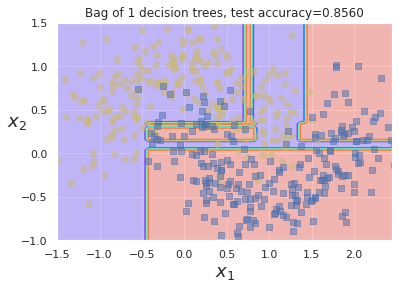

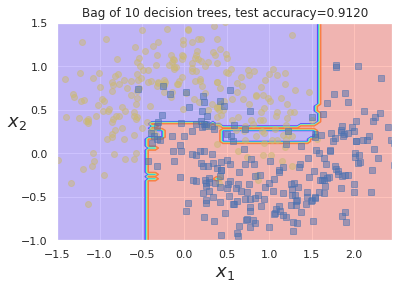

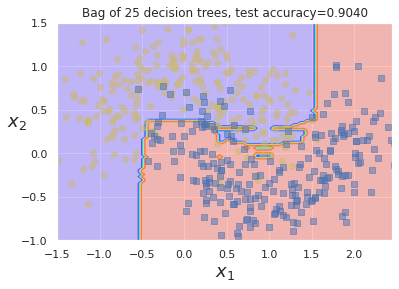

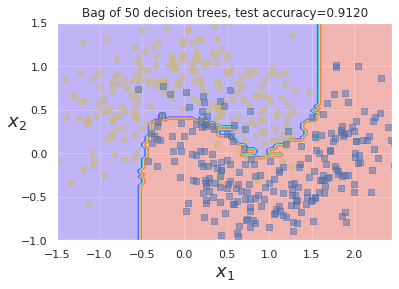

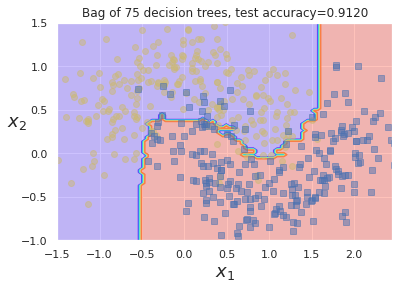

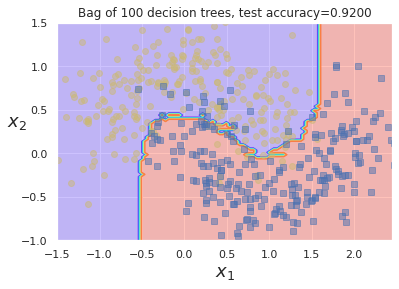

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_sizes = [1, 10, 25, 50, 75, 100]
for bag_size in bag_sizes:
    bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42), n_estimators=bag_size, max_samples=100, bootstrap=True, random_state=42
    )
    bag_clf.fit(X_train, y_train)
    y_pred = bag_clf.predict(X_test)
    bag_acc = accuracy_score(y_test, y_pred)

    plt.figure()
    plot_decision_boundary(bag_clf, X, y)
    plt.title("Bag of {} decision trees, test accuracy={:0.4f}".format(bag_size, bag_acc))

## Ансамбль моделей: бустинг (boosting)

Метод построения ансамбля моделей, при котором базовые модели обучаются последовательно и каждая последующая модель ансамбля применяется к результатам на выходе предыдущей.

Таким образом, метод бустинга реализует последовательную композицию алгоритмов обучения, в которой каждый алгоритм должен компенсировать ошибки, допущенные композицией предыдущих алгоритмов.

In [15]:
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

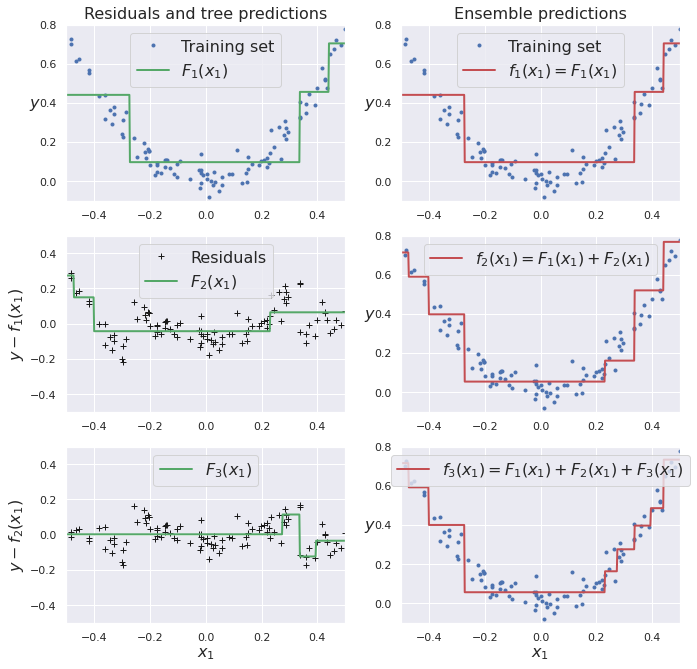

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$F_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$f_1(x_1) = F_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$F_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - f_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$f_2(x_1) = F_1(x_1) + F_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$F_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - f_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, 
                 axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$f_3(x_1) = F_1(x_1) + F_2(x_1) + F_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

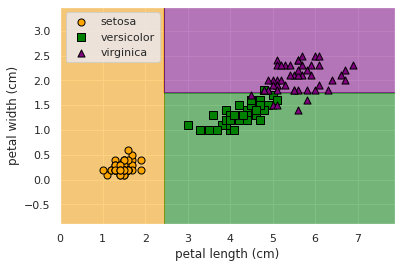

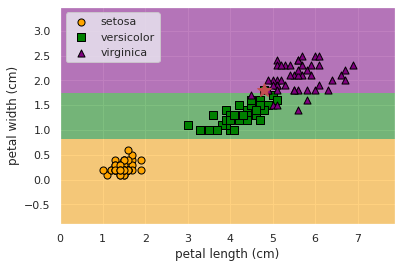

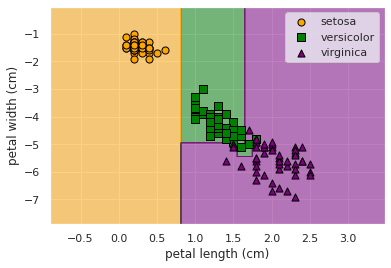

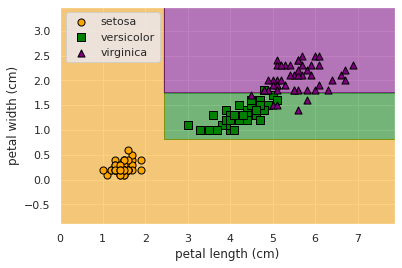

In [18]:
# Instability of decision tree classifier in 2d
# Based on https://github.com/ageron/handson-ml2/blob/master/06_decision_trees.ipynb


import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap


def plot_surface(clf, X, y, xnames, ynames):
    n_classes = 3
    plot_step = 0.02
    markers = ["o", "s", "^"]

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.xlabel(xnames[0])
    plt.ylabel(xnames[1])

    # we pick a color map to match that used by decision tree graphviz
    cmap = ListedColormap(["orange", "green", "purple"])
    # cmap = ListedColormap(['blue', 'orange', 'green'])
    # cmap = ListedColormap(sns.color_palette())
    plot_colors = [cmap(i) for i in range(4)]

    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)
    # Plot the training points
    for i, color, marker in zip(range(n_classes), plot_colors, markers):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0], X[idx, 1], label=ynames[i], edgecolor="black", color=color, s=50, cmap=cmap, marker=marker
        )
    plt.legend()


# Iris data, original
iris = load_iris()


# ndx = [0, 2] # sepal length, petal length
ndx = [2, 3]  # petal lenght and width
X = iris.data[:, ndx]
y = iris.target
xnames = [iris.feature_names[i] for i in ndx]
ynames = iris.target_names

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

plot_surface(tree_clf, X, y, xnames, ynames)
plt.show()


# Iris data, perturbed

# Find widest versicolor
ndx = y == 1
X1 = X[ndx, 1]
xmax = X1.max()
# exclude this point
ndx1 = X[:, 1] != xmax
ndx2 = y == 2
not_widest_versicolor = ndx1 | ndx2
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

plot_surface(tree_clf_tweaked, X, y, xnames, ynames)

class1 = y == 1
eq_max = X[:, 1] == xmax
ndx_omit = np.where(eq_max & class1)[0]
plt.plot(X[ndx_omit, 0], X[ndx_omit, 1], "r*", markersize=15)

plt.show()

# iris data, rotated

Xs = X
ys = y

angle = np.pi / 2
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = Xs.dot(rotation_matrix)
yr = ys

tree_clf_rot = DecisionTreeClassifier(random_state=42)
tree_clf_rot.fit(Xr, yr)

plot_surface(tree_clf_rot, Xr, yr, xnames, ynames)
plt.show()


## Ensemble of tree fit to original and tweaked data

if 0:
    from sklearn.ensemble import VotingClassifier

    eclf = VotingClassifier(estimators=[("orig", tree_clf), ("tweaked", tree_clf_tweaked)], voting="hard")
    plot_surface(eclf, X, y, xnames, ynames)

try:
    from probml_utils.prefit_voting_classifier import PrefitVotingClassifier
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils.prefit_voting_classifier import PrefitVotingClassifier

eclf = PrefitVotingClassifier(estimators=[("orig", tree_clf), ("tweaked", tree_clf_tweaked)], voting="soft")
plot_surface(eclf, X, y, xnames, ynames)
plt.show()

### Практический пример. Email Spam

Данные для этого практического примера состоят из информации о 4601 электронных сообщении (e-mail messages).
Задача состояла в том, чтобы разработать автоматический детектор спама, который мог бы отфильтровывать спам до того, как он засорит почтовые ящики пользователей. 
Для всех сообщения электронной почты имеется информация об истинном результате (тип письма) - письмо или спам, задача классификации (логистическая регрессия).

**Информация о данных.** Общее число : 4601 (1813 Spam = 39.4%). Общее число признаков: 58 (57 непрерывных, 1 метка класса).

Признаки:

|                          |                                                                                                       |
|--------------------------|-------------------------------------------------------------------------------------------------------|
|test                      |обозначает, является ли данная запись обучающей (0) или тестовой (1)                                   |
|word_freq_WORD            |процент слов в письме, которые совпадают WORD,<br>continuous real [0,100]                              |
|char_freq_CHAR            |процент символов в письме, которые совпадают CHAR,<br>continuous real [0,100]                          |
|capital_run_length_average|средняя длина непрерывных последовательностей заглавных букв,<br>continuous real [1,...]               |
|capital_run_length_longest|длина самой длинной непрерывной последовательности заглавных букв,<br>continuous integer [1,...]       |
|capital_run_length_total  |сумма длин непрерывных последовательностей заглавных букв,<br>continuous integer [1,...]               |
|spam                      |обозначает, было ли письмо признано спамом (1) или нет (0),<br>т.е. нежелательная коммерческая рассылка|

In [28]:
import statsmodels.api as sm
import numpy           as np
import pandas          as pd

# Performance of tree ensembles. Based on the email spam example from chapter 10 of "Elements of statistical learning". Code is from Andrey Gaskov's site:
# https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/Spam.ipynb
# Commented out IPython magic to ensure Python compatibility.

from matplotlib      import transforms, pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import BaggingClassifier
from catboost             import CatBoostClassifier, Pool, cv

# omit numpy warnings (don't do it in real work)
np.seterr(divide="ignore", invalid="ignore")
np.warnings.filterwarnings("ignore")
# %matplotlib inline

# define plots common properties and color constants
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 0.5
ORANGE, BLUE, PURPLE = "#FF8C00", "#0000FF", "#A020F0"
GRAY1, GRAY4, GRAY7 = "#231F20", "#646369", "#929497"


# we will calculate train and test error rates for all models
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

"""Get data"""

df = pd.read_csv(
    "https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Spam.txt?raw=True"
)
df.head(n = 10)



# PAGE 301. We coded spam as 1 and email as zero. A test set of size 1536 was
#           randomly chosen, leaving 3065 observations in the training set.
target = "spam"
columns = [
    "word_freq_make",
    "word_freq_address",
    "word_freq_all",
    "word_freq_3d",
    "word_freq_our",
    "word_freq_over",
    "word_freq_remove",
    "word_freq_internet",
    "word_freq_order",
    "word_freq_mail",
    "word_freq_receive",
    "word_freq_will",
    "word_freq_people",
    "word_freq_report",
    "word_freq_addresses",
    "word_freq_free",
    "word_freq_business",
    "word_freq_email",
    "word_freq_you",
    "word_freq_credit",
    "word_freq_your",
    "word_freq_font",
    "word_freq_000",
    "word_freq_money",
    "word_freq_hp",
    "word_freq_hpl",
    "word_freq_george",
    "word_freq_650",
    "word_freq_lab",
    "word_freq_labs",
    "word_freq_telnet",
    "word_freq_857",
    "word_freq_data",
    "word_freq_415",
    "word_freq_85",
    "word_freq_technology",
    "word_freq_1999",
    "word_freq_parts",
    "word_freq_pm",
    "word_freq_direct",
    "word_freq_cs",
    "word_freq_meeting",
    "word_freq_original",
    "word_freq_project",
    "word_freq_re",
    "word_freq_edu",
    "word_freq_table",
    "word_freq_conference",
    "char_freq_;",
    "char_freq_(",
    "char_freq_[",
    "char_freq_!",
    "char_freq_$",
    "char_freq_#",
    "capital_run_length_average",
    "capital_run_length_longest",
    "capital_run_length_total",
]
# let's give columns more compact names
features = [
    "make",
    "address",
    "all",
    "3d",
    "our",
    "over",
    "remove",
    "internet",
    "order",
    "mail",
    "receive",
    "will",
    "people",
    "report",
    "addresses",
    "free",
    "business",
    "email",
    "you",
    "credit",
    "your",
    "font",
    "000",
    "money",
    "hp",
    "hpl",
    "george",
    "650",
    "lab",
    "labs",
    "telnet",
    "857",
    "data",
    "415",
    "85",
    "technology",
    "1999",
    "parts",
    "pm",
    "direct",
    "cs",
    "meeting",
    "original",
    "project",
    "re",
    "edu",
    "table",
    "conference",
    "ch_;",
    "ch(",
    "ch[",
    "ch!",
    "ch$",
    "ch#",
    "CAPAVE",
    "CAPMAX",
    "CAPTOT",
]

X, y = df[columns].values, df[target].values

# Переделать под кросс валидацию
# split by test column value
is_test = df.test.values
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]

""" Logistic regression

As a sanity check, we try to match p301  test error rate of 7.6%.

"""
lr_clf = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
# 0.5 is a threshold
y_test_hat = (lr_clf.predict(sm.add_constant(X_test)) > 0.5).astype(int)
lr_error_rate = error_rate(y_test, y_test_hat)
print(f"Logistic Regression Test Error Rate: {lr_error_rate*100:.1f}%")

# PAGE 590. A random forest classifier achieves 4.88% misclassification error
#           on the spam test data, which compares well with all other methods,
#           and is not significantly worse than gradient boosting at 4.5%.
ntrees_list = [10, 50, 100, 200, 300, 400, 500]

bag_errors = []
for ntrees in ntrees_list:
    bag_clf = BaggingClassifier(n_estimators=ntrees, random_state=10, bootstrap=True).fit(X_train, y_train)
    y_test_hat = bag_clf.predict(X_test)
    bag_error_rate = error_rate(y_test, y_test_hat)
    bag_errors.append(bag_error_rate)
    print(f"Bagged {ntrees} trees, test error {bag_error_rate*100:.1f}%")

rf_errors = []
for ntrees in ntrees_list:
    rf_clf = RandomForestClassifier(n_estimators=ntrees, random_state=10).fit(X_train, y_train)
    y_test_hat = rf_clf.predict(X_test)
    rf_error_rate = error_rate(y_test, y_test_hat)
    rf_errors.append(rf_error_rate)
    print(f"RF {ntrees} trees, test error {rf_error_rate*100:.1f}%")

boost_errors = []
for ntrees in ntrees_list:
    boost_clf = CatBoostClassifier(iterations=ntrees, random_state=10, learning_rate=0.2, verbose=False).fit(
        X_train, y_train
    )
    y_test_hat = boost_clf.predict(X_test)
    boost_error_rate = error_rate(y_test, y_test_hat)
    boost_errors.append(boost_error_rate)
    print(f"Boosting {ntrees} trees, test error {boost_error_rate*100:.1f}%")

Logistic Regression Test Error Rate: 7.6%
Bagged 10 trees, test error 5.9%
Bagged 50 trees, test error 5.5%
Bagged 100 trees, test error 5.4%
Bagged 200 trees, test error 5.5%
Bagged 300 trees, test error 5.5%
Bagged 400 trees, test error 5.4%
Bagged 500 trees, test error 5.6%
RF 10 trees, test error 6.3%
RF 50 trees, test error 5.0%
RF 100 trees, test error 4.9%
RF 200 trees, test error 4.8%
RF 300 trees, test error 4.9%
RF 400 trees, test error 4.8%
RF 500 trees, test error 4.8%
Boosting 10 trees, test error 6.2%
Boosting 50 trees, test error 5.4%
Boosting 100 trees, test error 4.7%
Boosting 200 trees, test error 4.6%
Boosting 300 trees, test error 4.8%
Boosting 400 trees, test error 4.6%
Boosting 500 trees, test error 4.4%


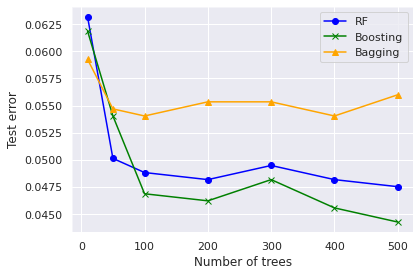

In [27]:
plt.figure()
plt.plot(ntrees_list, rf_errors   , "o-", color="blue"  , label="RF"      )
plt.plot(ntrees_list, boost_errors, "x-", color="green" , label="Boosting")
plt.plot(ntrees_list, bag_errors  , "^-", color="orange", label="Bagging" )
plt.legend()
plt.xlabel("Number of trees")
plt.ylabel("Test error")
plt.tight_layout()